## Анализ результатов PlaceRecognition

In [1]:
from skimage.io import imread
from sklearn.manifold import TSNE
import os
import faiss
import torch
from omegaconf import OmegaConf
from hydra.utils import instantiate
import numpy as np
import matplotlib.pyplot as plt
import MinkowskiEngine as ME
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/kirill/TopoSLAM/OpenPlaceRecognition/src')
from opr.models.place_recognition import MinkLoc3D
from opr.datasets.augmentations import DefaultHM3DImageTransform

### MinkLoc3D

In [3]:
graph_dir = '/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/test_minkloc3d_by_odometry_1/graph_data'
pr_results_dir = '/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/test_minkloc3d_by_odometry_1/place_recognition_data'

In [4]:
vertex_ids = [int(x) for x in os.listdir(graph_dir)]
vertex_ids.sort()
poses = []
clouds = []
descriptors = []
for i in vertex_ids:
    vertex_dir = os.path.join(graph_dir, str(i))
    pose = np.loadtxt(os.path.join(vertex_dir, 'pose_stamped.txt'))
    cloud = np.load(os.path.join(vertex_dir, 'cloud.npz'))['arr_0']
    descriptor = np.loadtxt(os.path.join(vertex_dir, 'descriptor.txt'))
    poses.append(pose)
    clouds.append(cloud)
    descriptors.append(descriptor)
poses = np.array(poses)
descriptors = np.array(descriptors)

In [5]:
index = faiss.IndexFlatL2(256)
for desc in descriptors:
    index.add(desc[np.newaxis, :])

#### Подсчет реальных и дескрипторных расстояний

In [6]:
k = 5
descriptor_dists = []
real_dists = []
for i in vertex_ids:
    pose = poses[i]
    dist, pred_i = index.search(descriptors[i][np.newaxis, :], k)
    dist = dist[0, 1:]
    pred_i = pred_i[0, 1:]
    real_dist = np.sqrt(np.sum((pose[1:3] - poses[pred_i, 1:3]) ** 2, axis=1))
    descriptor_dists.append(dist)
    real_dists.append(real_dist)
    print('i:', i)
    print('Vertex ids:', pred_i)
    print('Dists:', np.round(dist, 2))
    print('Real dists:', np.round(real_dist, 2))
descriptor_dists = np.array(descriptor_dists)
real_dists = np.array(real_dists)

i: 0
Vertex ids: [70  8 60 61]
Dists: [5.12 6.64 6.79 6.79]
Real dists: [ 7.18 15.92  5.22  5.22]
i: 1
Vertex ids: [ 8 17 15  6]
Dists: [3.43 3.49 3.54 3.62]
Real dists: [12.13  3.43 11.5   9.56]
i: 2
Vertex ids: [18 39 40 41]
Dists: [4.56 4.99 4.99 4.99]
Real dists: [ 8.52 13.8  13.8  13.8 ]
i: 3
Vertex ids: [16 69  9 17]
Dists: [2.49 2.64 3.19 3.32]
Real dists: [4.89 4.71 7.09 4.99]
i: 4
Vertex ids: [ 5 16  3 67]
Dists: [2.58 3.25 3.59 3.9 ]
Real dists: [0.3  5.02 3.37 4.63]
i: 5
Vertex ids: [ 4 16  3 38]
Dists: [2.58 3.25 4.06 4.22]
Real dists: [0.3  5.29 3.6  8.3 ]
i: 6
Vertex ids: [ 1  8  7 20]
Dists: [3.62 3.65 3.77 3.98]
Real dists: [ 9.56  2.57  1.69 13.98]
i: 7
Vertex ids: [8 6 9 1]
Dists: [3.36 3.77 4.48 4.51]
Real dists: [ 1.09  1.69  1.45 11.19]
i: 8
Vertex ids: [ 9  7 39 40]
Dists: [2.84 3.36 3.42 3.42]
Real dists: [ 0.4   1.09 11.42 11.42]
i: 9
Vertex ids: [ 8  3 43 13]
Dists: [2.84 3.19 3.3  3.33]
Real dists: [ 0.4   7.09 12.58  3.23]
i: 10
Vertex ids: [11 12  8 53]
Dist

In [7]:
tsne = TSNE(n_components=2)

In [8]:
descriptors_vis = tsne.fit_transform(descriptors)

#### Визуализация T-SNE

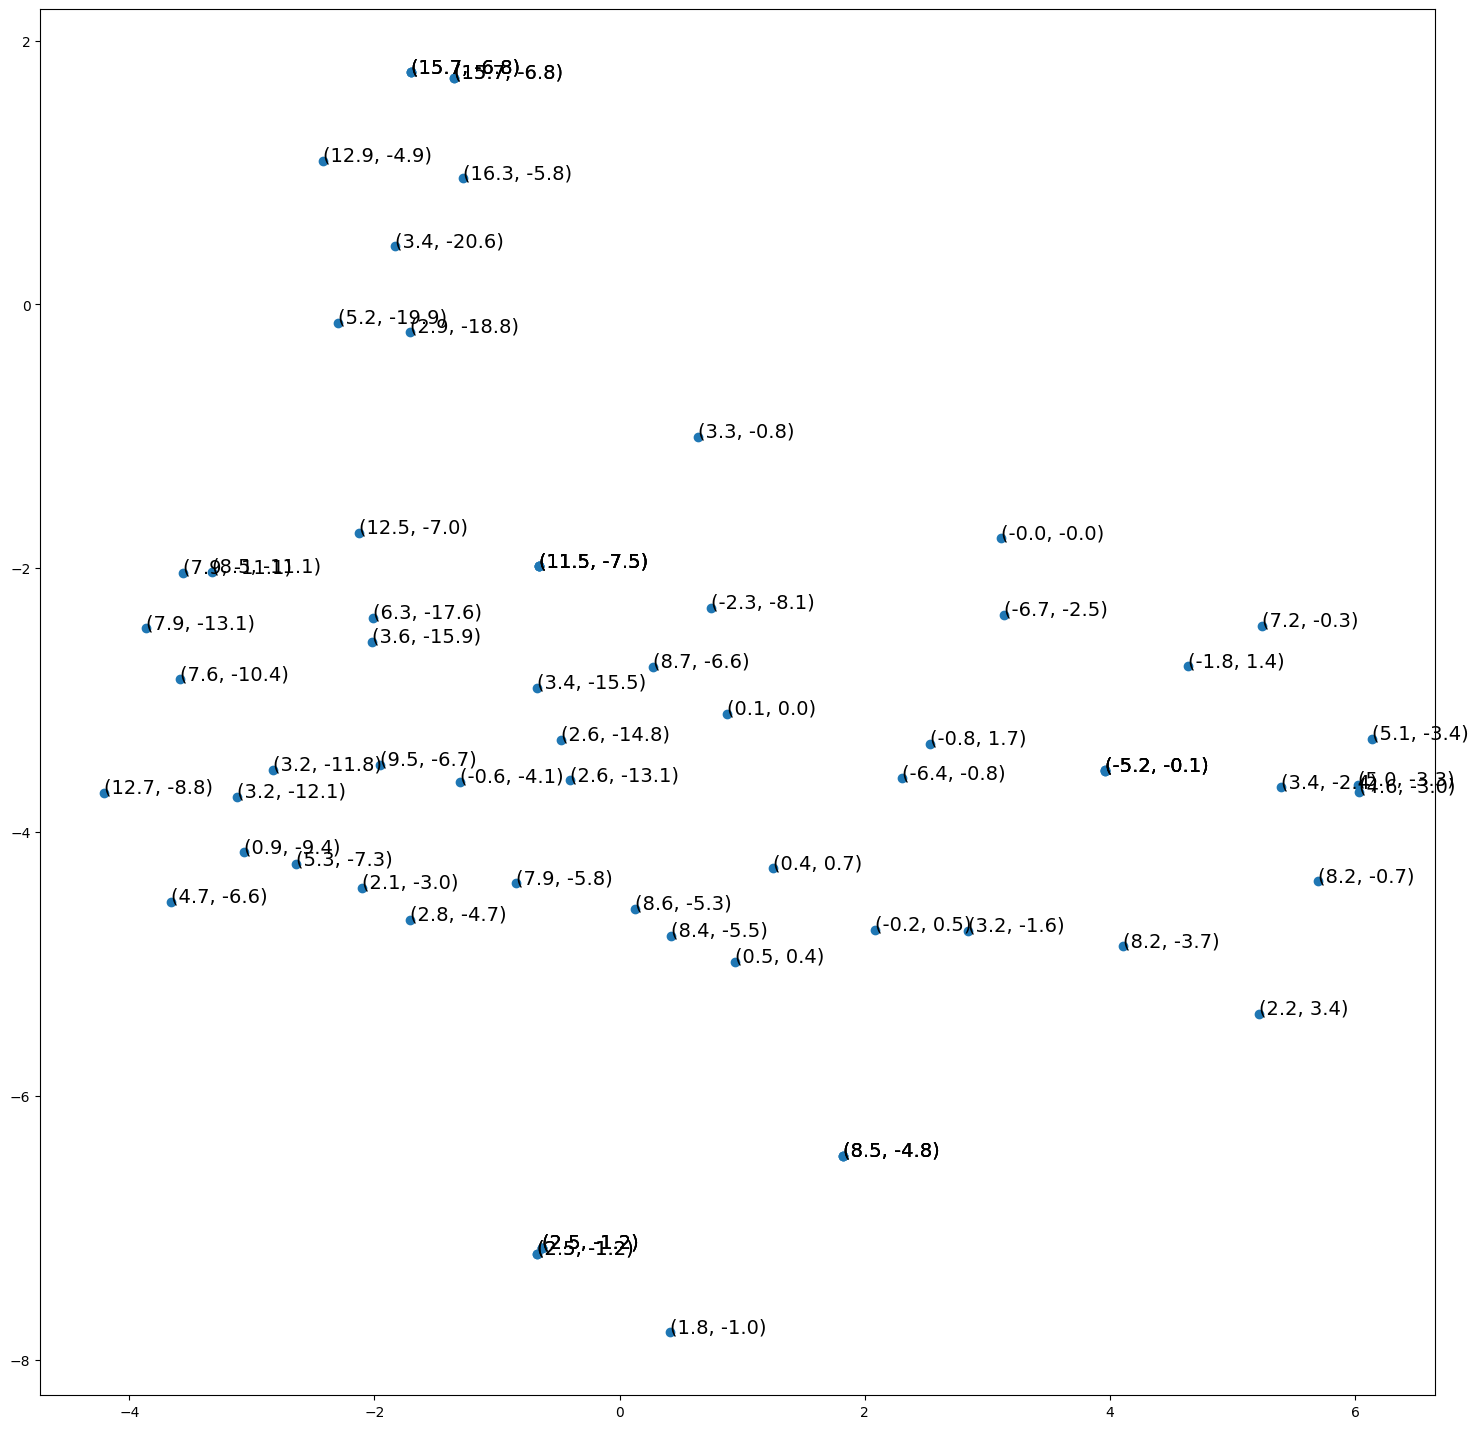

In [9]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(descriptors_vis[:, 0], descriptors_vis[:, 1])
for i in vertex_ids:
    ax.annotate('({}, {})'.format(round(poses[i][1], 1), round(poses[i][2], 1)), descriptors_vis[i, :2], fontsize=14)

In [10]:
def preprocess_input(input_data):
    """Preprocess input data."""
    pointcloud_quantization_size = 0.5
    out_dict: Dict[str, Tensor] = {}
    for key in input_data:
        if key.startswith("image_"):
            out_dict[f"images_{key[6:]}"] = input_data[key].unsqueeze(0).cuda()
        elif key.startswith("mask_"):
            out_dict[f"masks_{key[5:]}"] = input_data[key].unsqueeze(0).cuda()
        elif key == "pointcloud_lidar_coords":
            quantized_coords, quantized_feats = ME.utils.sparse_quantize(
                coordinates=input_data["pointcloud_lidar_coords"],
                features=input_data["pointcloud_lidar_feats"],
                quantization_size=pointcloud_quantization_size,
            )
            out_dict["pointclouds_lidar_coords"] = ME.utils.batched_coordinates([quantized_coords]).cuda()
            out_dict["pointclouds_lidar_feats"] = quantized_feats.cuda()
    return out_dict

def get_minkloc3d_descriptor(model, cloud):
    input_data = {'pointcloud_lidar_coords': torch.Tensor(cloud[:, :3]).cuda(),
                'pointcloud_lidar_feats': torch.ones((cloud.shape[0], 1)).cuda()}
    batch = preprocess_input(input_data)
    descriptor = model(batch)["final_descriptor"].detach().cpu().numpy()
    return descriptor

In [11]:
WEIGHTS_PATH = "/home/kirill/TopoSLAM/OpenPlaceRecognition/weights/place_recognition/minkloc3d_nclt.pth"
model_minkloc3d = MinkLoc3D()
model_minkloc3d.load_state_dict(torch.load(WEIGHTS_PATH))
model_minkloc3d = model_minkloc3d.to("cuda")
_ = model_minkloc3d.eval()

#### Проверка устойчивости к смещению и повороту

In [12]:
i = 14
cloud = clouds[i]
src_desc = get_minkloc3d_descriptor(model_minkloc3d, cloud)
print('Nearest descriptor dist in graph:', real_dists[i, 0])
for i in range(-1, 2):
    for j in range(-1, 2):
        dst_desc = get_minkloc3d_descriptor(model_minkloc3d, cloud[:, :3] + [i, j, 0])
        print('Descriptor dist for shift ({}, {}): {}'.format(i, j, np.sum((src_desc - dst_desc) ** 2)))

Nearest descriptor dist in graph: 2.7575743045875494
Descriptor dist for shift (-1, -1): 2.288605213165283
Descriptor dist for shift (-1, 0): 1.7791202068328857
Descriptor dist for shift (-1, 1): 2.5632052421569824
Descriptor dist for shift (0, -1): 1.2708626985549927
Descriptor dist for shift (0, 0): 1.3578027591165664e-13
Descriptor dist for shift (0, 1): 1.7778420448303223
Descriptor dist for shift (1, -1): 2.127988576889038
Descriptor dist for shift (1, 0): 1.5283414125442505
Descriptor dist for shift (1, 1): 2.676393985748291


In [13]:
def rotate_pcd(cloud, angle):
    cloud_rotated = cloud.copy()
    cloud_rotated[:, 0] = cloud[:, 0] * np.cos(angle) + cloud[:, 1] * np.sin(angle)
    cloud_rotated[:, 1] = -cloud[:, 0] * np.sin(angle) + cloud[:, 1] * np.cos(angle)
    return cloud_rotated

In [14]:
i = 45
cloud = clouds[i]
src_desc = get_minkloc3d_descriptor(model_minkloc3d, cloud)
print('Nearest descriptor dist in graph:', real_dists[i, 0])
for i in range(12):
    angle = np.pi / 6 * i
    cloud_rotated = rotate_pcd(cloud[:, :3], angle)
    dst_desc = get_minkloc3d_descriptor(model_minkloc3d, cloud_rotated)
    print('Descriptor dist for {} degrees rotation: {}'.format(30 * i, np.sum((src_desc - dst_desc) ** 2)))

Nearest descriptor dist in graph: 1.3029776751369488
Descriptor dist for 0 degrees rotation: 0.0
Descriptor dist for 30 degrees rotation: 4.167943954467773
Descriptor dist for 60 degrees rotation: 7.421015739440918
Descriptor dist for 90 degrees rotation: 6.758486270904541
Descriptor dist for 120 degrees rotation: 6.545894622802734
Descriptor dist for 150 degrees rotation: 5.682641983032227
Descriptor dist for 180 degrees rotation: 3.159384250640869
Descriptor dist for 210 degrees rotation: 5.27733039855957
Descriptor dist for 240 degrees rotation: 6.79774808883667
Descriptor dist for 270 degrees rotation: 7.832940578460693
Descriptor dist for 300 degrees rotation: 6.0882887840271
Descriptor dist for 330 degrees rotation: 5.192554473876953


### MSSPlace

In [102]:
graph_dir = '/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/test_husky_rosbag_mssplace_12/graph_data'
pr_results_dir = '/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/test_husky_rosbag_mssplace_12/place_recognition_data'

In [157]:
poses = []
subdirs = os.listdir(graph_dir)
subdirs.sort(key=lambda i: int(i))
for subdir in subdirs:
    pose_stamped = np.loadtxt(os.path.join(graph_dir, subdir, 'pose_stamped.txt'))
    poses.append(pose_stamped[1:])
poses = np.array(poses)

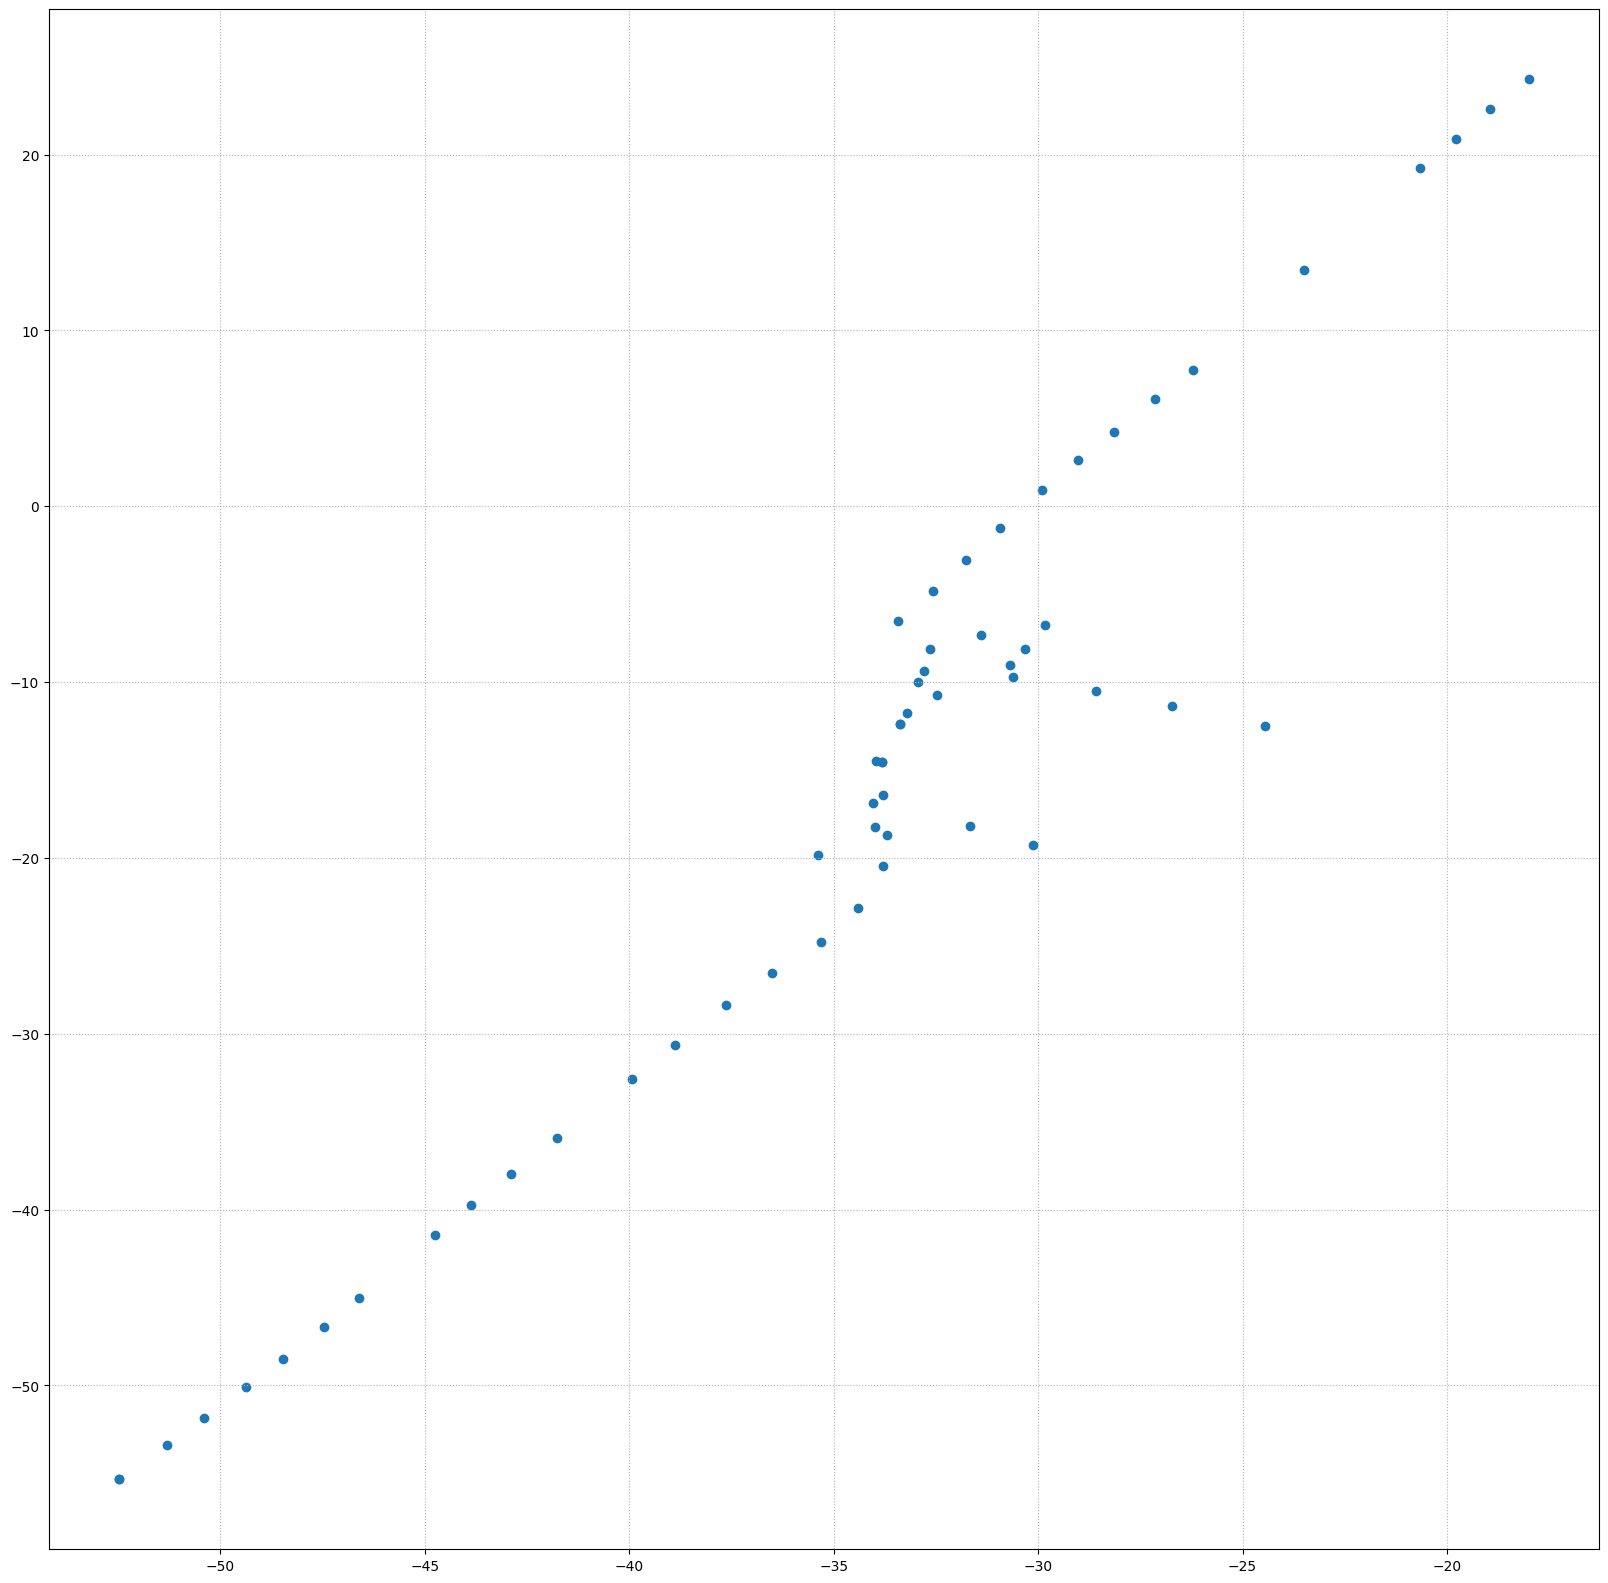

In [158]:
plt.figure(figsize=(20, 20))
plt.scatter(poses[:, 0], poses[:, 1])
plt.grid(ls=':')

In [159]:
pose_diff = poses[1:] - poses[:-1]
print('Traveled distance:', np.sqrt(pose_diff[:, 0] ** 2 + pose_diff[:, 1] ** 2).sum())

Traveled distance: 203.64189079238002


In [115]:
import six
cStringIO = six.StringIO; from pypcd import pypcd

ModuleNotFoundError: No module named 'cStringIO'

In [135]:
import open3d as o3d
from scipy.spatial.transform import Rotation

In [164]:
pcd_file = '/media/kirill/2E493B983C144ACC/rosbags/ITLPCampus/maps/indoor/floor_3/floor_3_low.pcd'
cloud = o3d.io.read_point_cloud(pcd_file)
R = Rotation.from_rotvec([0.05, 0, 0]).as_matrix()
cloud = cloud.rotate(R)

In [165]:
points = np.asarray(cloud.points)

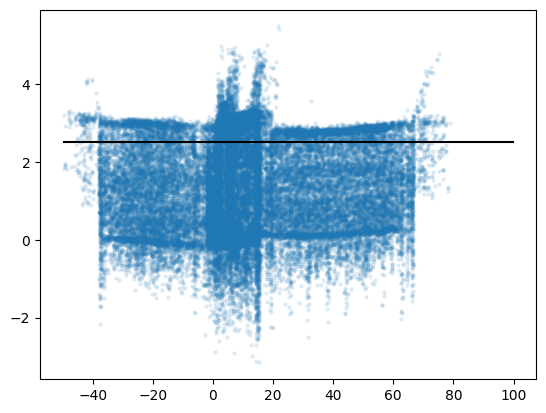

In [163]:
plt.scatter(points[::17, 0], points[::17, 2], s=5, alpha=0.1)
plt.hlines(2.5, -50, 100, color='black')

(-1.0, 3.0)

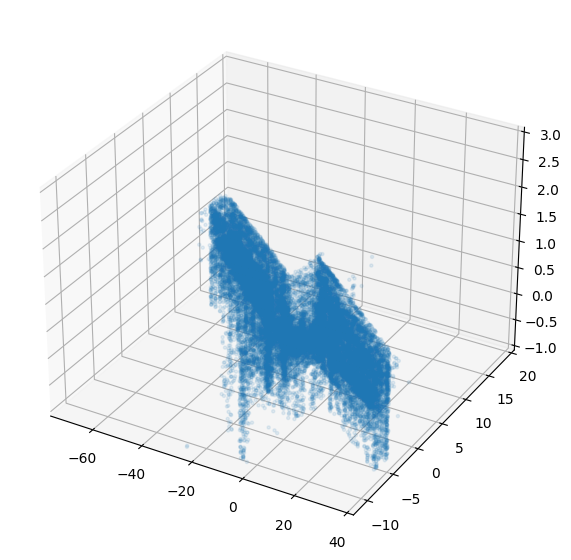

In [150]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 7))
points = points[(points[:, 2] < 1) * (points[:, 2] > -1)]
ax.scatter3D(-points[::17, 0], -points[::17, 1], points[::17, 2], s=5, alpha=0.1)
ax.set_xlim((-75, 40))
ax.set_ylim((-12, 20))
ax.set_zlim((-1, 3))

In [16]:
image_transform = DefaultHM3DImageTransform(train=False)

In [17]:
WEIGHTS_PATH = "/home/kirill/TopoSLAM/OpenPlaceRecognition/weights/place_recognition/mssplace_multimodal_full_pcd.pth"
MODEL_CONFIG_PATH = "/home/kirill/TopoSLAM/OpenPlaceRecognition/configs/model/place_recognition/resnet18-seqgem_minkloc3dv2.yaml"
model_config = OmegaConf.load(MODEL_CONFIG_PATH)
model_mssplace = instantiate(model_config)
model_mssplace.load_state_dict(torch.load(WEIGHTS_PATH)["model_state_dict"])
model_mssplace = model_mssplace.to("cuda")
_ = model_mssplace.eval()

In [18]:
def get_mssplace_descriptor(model, img_front, img_back, cloud):
    img_front_tensor = torch.Tensor(img_front).cuda()
    img_back_tensor = torch.Tensor(img_back).cuda()
    #img_front_tensor = torch.permute(img_front_tensor, (2, 0, 1))
    #img_back_tensor = torch.permute(img_back_tensor, (2, 0, 1))
    input_data = {
             'image_front': img_front_tensor,
             'image_back': img_back_tensor,
             'pointcloud_lidar_coords': torch.Tensor(cloud[:, :3]).cuda(),
             'pointcloud_lidar_feats': torch.ones((cloud.shape[0], 1)).cuda()
             }
    batch = preprocess_input(input_data)
    print(batch.keys())
    #batch['pointclouds_lidar_coords'] = torch.unsqueeze(batch['pointclouds_lidar_coords'], 0)
    #batch['pointclouds_lidar_feats'] = torch.unsqueeze(batch['pointclouds_lidar_feats'], 0)
    for k in batch:
        print(k, batch[k].shape)
    descriptor = model(batch)["final_descriptor"].detach().cpu().numpy()
    return descriptor

In [19]:
vertex_ids = [int(x) for x in os.listdir(graph_dir)]
vertex_ids.sort()
poses = []
imgs_front = []
imgs_back = []
clouds = []
descriptors = []
for i in vertex_ids:
    vertex_dir = os.path.join(graph_dir, str(i))
    pose = np.loadtxt(os.path.join(vertex_dir, 'pose_stamped.txt'))
    cloud = np.load(os.path.join(vertex_dir, 'cloud.npz'))['arr_0']
    img_front = imread(os.path.join(vertex_dir, 'img_front.png'))
    img_front_transformed = image_transform(img_front)
    img_back = imread(os.path.join(vertex_dir, 'img_back.png'))
    img_back_transformed = image_transform(img_back)
    cloud = np.load(os.path.join(vertex_dir, 'cloud.npz'))['arr_0']
    #descriptor = np.loadtxt(os.path.join(vertex_dir, 'descriptor.txt'))
    descriptor = get_mssplace_descriptor(model_mssplace, img_front_transformed, img_back_transformed, cloud)
    poses.append(pose)
    imgs_front.append(img_front)
    imgs_back.append(img_back)
    clouds.append(cloud)
    descriptors.append(descriptor)
poses = np.array(poses)
descriptors = np.array(descriptors)

dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([946, 4])
pointclouds_lidar_feats torch.Size([946, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([643, 4])
pointclouds_lidar_feats torch.Size([643, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([476, 4])
pointclouds_lidar_feats torch.Size([476, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
poi

dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([485, 4])
pointclouds_lidar_feats torch.Size([485, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([611, 4])
pointclouds_lidar_feats torch.Size([611, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([711, 4])
pointclouds_lidar_feats torch.Size([711, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
poi

dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([1006, 4])
pointclouds_lidar_feats torch.Size([1006, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([1263, 4])
pointclouds_lidar_feats torch.Size([1263, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([1353, 4])
pointclouds_lidar_feats torch.Size([1353, 1])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288

In [20]:
index = faiss.IndexFlatL2(512)
for desc in descriptors:
    index.add(desc)#[np.newaxis, :])

In [21]:
def get_real_dists(pose, vertex_ids):
    return np.sqrt(np.sum((pose[1:3] - poses[vertex_ids, 1:3]) ** 2, axis=1))

#### Подсчет реальных и дескрипторных расстояний

In [22]:
k = 5
descriptor_dists = []
real_dists = []
for i in vertex_ids:
    pose = poses[i]
    dist, pred_i = index.search(descriptors[i], k)
    dist = dist[0, 1:]
    pred_i = pred_i[0, 1:]
    real_dist = np.sqrt(np.sum((pose[1:3] - poses[pred_i, 1:3]) ** 2, axis=1))
    descriptor_dists.append(dist)
    real_dists.append(real_dist)
    print('i:', i)
    print('Vertex ids:', pred_i)
    print('Dists:', np.round(dist, 2))
    print('Real dists:', np.round(real_dist, 2))
descriptor_dists = np.array(descriptor_dists)
real_dists = np.array(real_dists)

i: 0
Vertex ids: [27 18 56 37]
Dists: [5.75 6.38 6.39 6.56]
Real dists: [32.4  24.72  6.48 23.25]
i: 1
Vertex ids: [57 54  2 58]
Dists: [5.   5.96 7.   7.98]
Real dists: [7.36 6.7  1.86 5.51]
i: 2
Vertex ids: [58 57  1 54]
Dists: [6.22 6.39 7.   8.29]
Real dists: [7.3  9.1  1.86 7.91]
i: 3
Vertex ids: [56 59 51 37]
Dists: [5.69 5.92 6.45 6.94]
Real dists: [ 9.4   7.07  5.3  19.36]
i: 4
Vertex ids: [22  5  7 34]
Dists: [7.48 7.54 7.69 8.17]
Real dists: [23.64  0.54  3.61 20.93]
i: 5
Vertex ids: [ 6 60 16  4]
Dists: [6.81 7.06 7.51 7.54]
Real dists: [ 1.26  6.92 17.89  0.54]
i: 6
Vertex ids: [16 14  7 38]
Dists: [6.13 6.32 6.53 6.71]
Real dists: [16.62 12.88  1.84 15.91]
i: 7
Vertex ids: [15  8  9 11]
Dists: [4.63 4.93 5.01 5.16]
Real dists: [12.91  1.87  3.67  7.35]
i: 8
Vertex ids: [ 9  7 15 13]
Dists: [4.87 4.93 5.2  5.74]
Real dists: [ 1.81  1.87 11.04  7.37]
i: 9
Vertex ids: [11 12 10 14]
Dists: [4.39 4.39 4.61 4.85]
Real dists: [3.68 3.68 1.85 7.36]
i: 10
Vertex ids: [11 12 14  9]


In [23]:
tsne = TSNE(n_components=2)

In [24]:
descriptors_vis = tsne.fit_transform(descriptors[:, 0, :])

#### Визуализация T-SNE

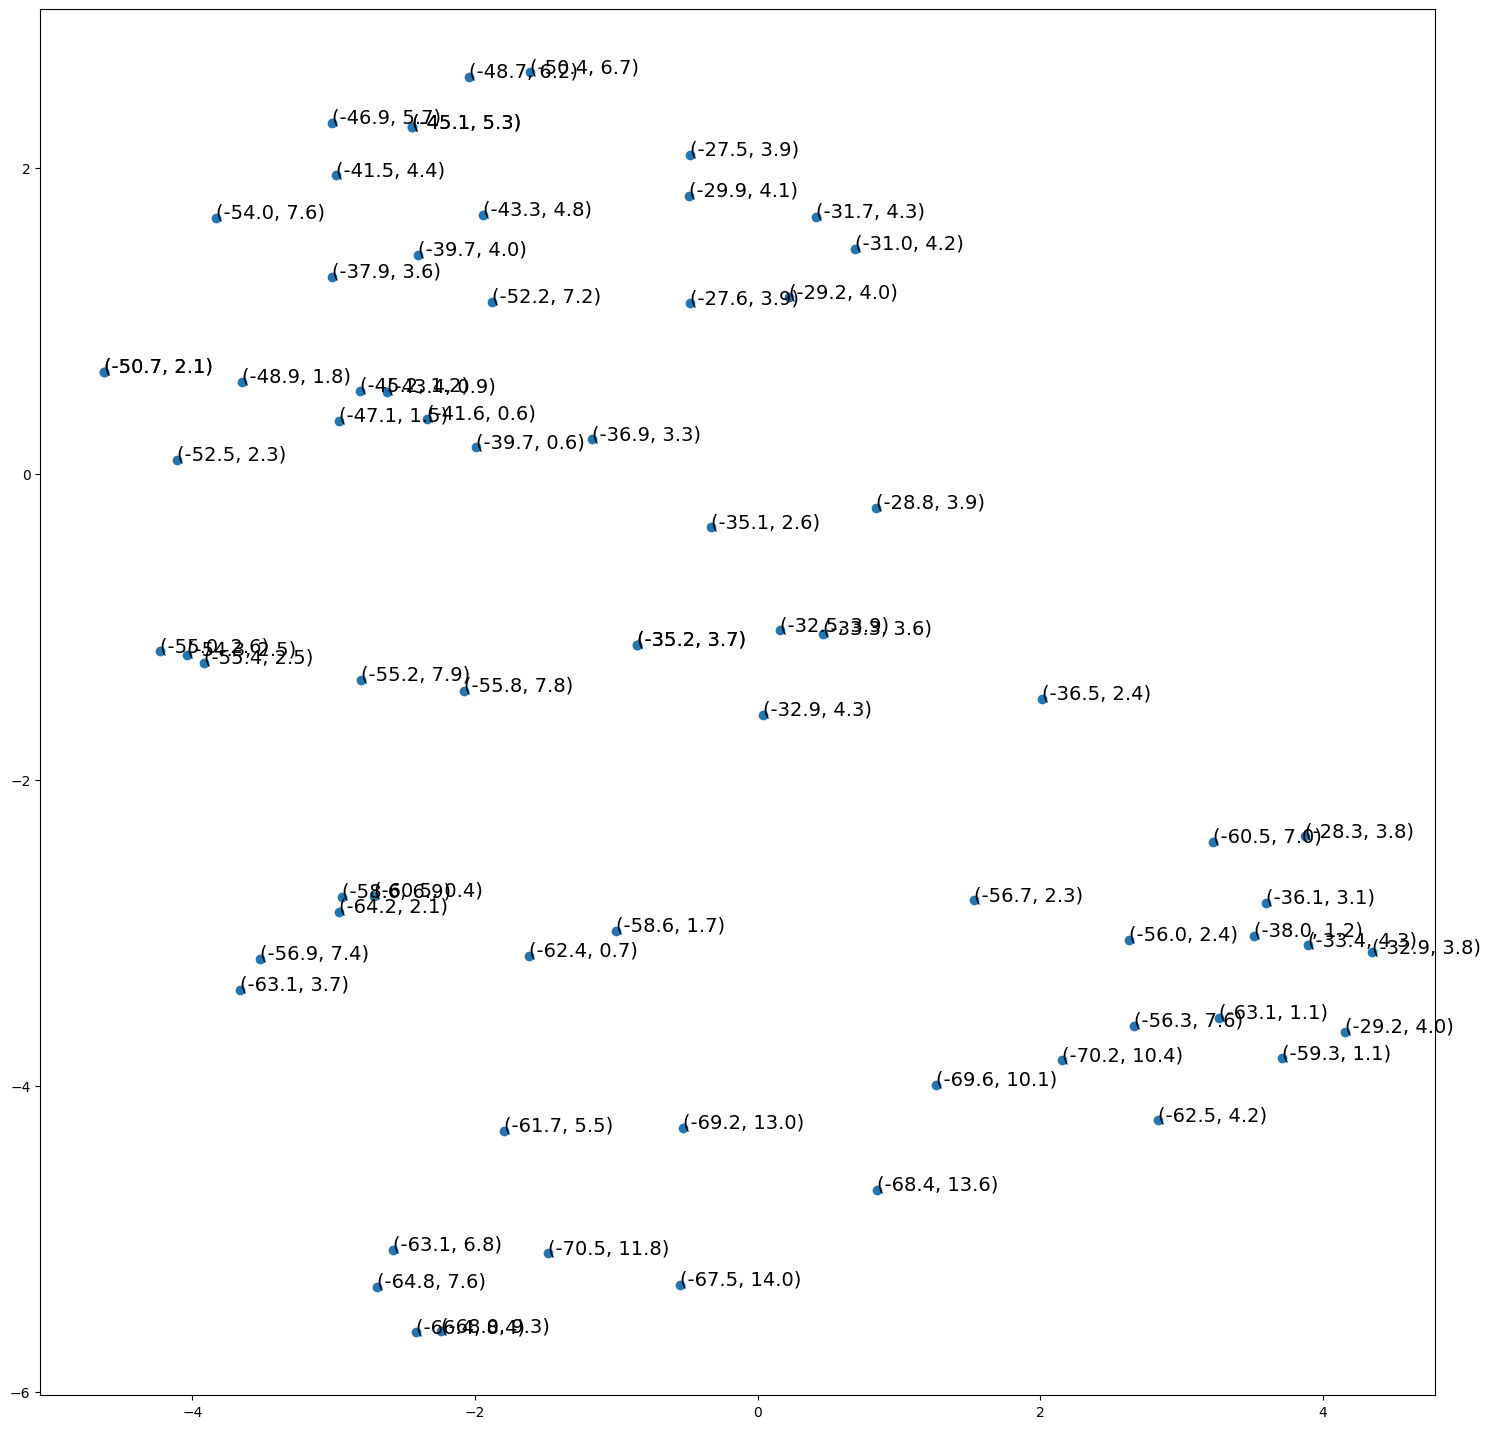

In [25]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(descriptors_vis[:, 0], descriptors_vis[:, 1])
for i in vertex_ids:
    ax.annotate('({}, {})'.format(round(poses[i][1], 1), round(poses[i][2], 1)), descriptors_vis[i, :2], fontsize=14)

#### Проверка адекватности модели на ближайших картинках

In [44]:
f1 = 683
f2 = 910
cx1 = 615
cy1 = 345
cx2 = 648
cy2 = 354

In [45]:
nearest_id

39

In [52]:
from skimage.transform import resize

torch.Size([3, 160, 288])
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([694, 4])
pointclouds_lidar_feats torch.Size([694, 1])
Nearest id: 40
dict_keys(['images_front', 'images_back', 'pointclouds_lidar_coords', 'pointclouds_lidar_feats'])
images_front torch.Size([1, 3, 160, 288])
images_back torch.Size([1, 3, 160, 288])
pointclouds_lidar_coords torch.Size([762, 4])
pointclouds_lidar_feats torch.Size([762, 1])


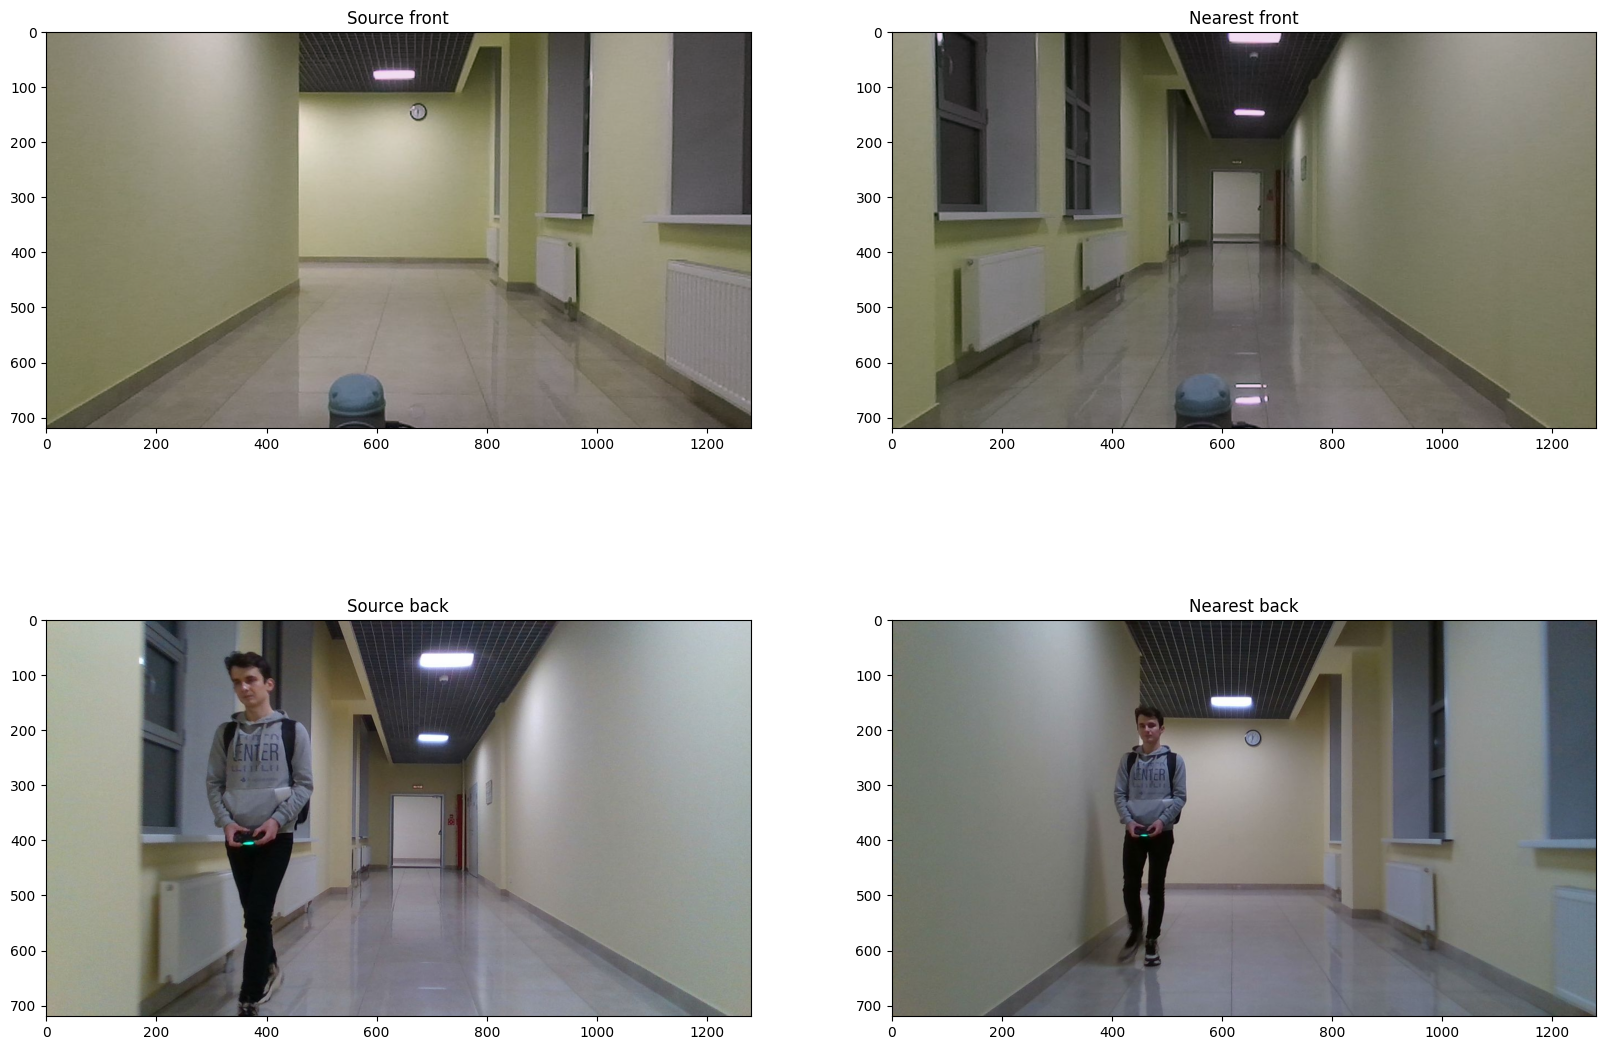

In [89]:
i = 14
img_front_src = imgs_front[i]
img_front_src_warped = img_front_src[int(cy1 - f1 / f2 * cy2):int(cy1 + f1 / f2 * (720 - cy2)), 
                                     int(cx1 - f1 / f2 * cx2):int(cx1 + f1 / f2 * (1280 - cx2))]
img_front_src_warped = resize(img_front_src_warped, (720, 1280)) / np.array([1.05, 1.15, 1.05])
img_front_transformed = image_transform(img_front_src_warped)
img_back_src = imgs_back[i]
img_back_transformed = image_transform(img_back_src)
print(img_back_transformed.shape)
cloud_src = clouds[i]
src_desc = get_mssplace_descriptor(model_mssplace, img_front_transformed, img_back_transformed, cloud_src)
all_without_i = [j for j in vertex_ids if j != i and abs(poses[i, 3] - poses[j, 3]) > 2]
rel_dists = np.sqrt(np.sum((poses[i, 1:3] - poses[all_without_i, 1:3]) ** 2, axis=1))
nearest_id = all_without_i[np.argmin(rel_dists)]
nearest_id = 40
print('Nearest id:', nearest_id)
img_front_dst = imgs_front[nearest_id]
img_front_dst_warped = img_front_dst[int(cy1 - f1 / f2 * cy2):int(cy1 + f1 / f2 * (720 - cy2)), 
                                     int(cx1 - f1 / f2 * cx2):int(cx1 + f1 / f2 * (1280 - cx2))]
img_front_dst_warped = resize(img_front_dst_warped, (720, 1280)) / np.array([1.05, 1.15, 1.05])
img_front_transformed = image_transform(img_front_dst_warped)
img_back_dst = imgs_back[nearest_id]
img_back_transformed = image_transform(img_back_dst)
cloud_dst = clouds[nearest_id]
dst_desc = get_mssplace_descriptor(model_mssplace, img_front_transformed, img_back_transformed, cloud_dst)
plt.figure(figsize=(20, 14))
plt.subplot(2, 2, 1)
plt.title('Source front')
plt.imshow(img_front_src_warped)
plt.subplot(2, 2, 2)
plt.title('Nearest front')
plt.imshow(img_front_dst_warped)
plt.subplot(2, 2, 3)
plt.title('Source back')
plt.imshow(img_back_src)
plt.subplot(2, 2, 4)
plt.title('Nearest back')
plt.imshow(img_back_dst)

In [90]:
np.sqrt(np.sum((src_desc[0] - dst_desc[0]) ** 2))

2.2278287

In [74]:
img_front_src_warped[250, 600] * 255 / img_back_dst[250, 600]

array([1.13513514, 1.25      , 1.05084746])

In [33]:
poses[i, 3]

-0.27581562822832295

In [39]:
i = 15
all_without_i = [j for j in vertex_ids if j != i and abs(poses[j, 3] - poses[i, 3]) > 2]
rel_dists = np.sqrt(np.sum((poses[i, 1:3] - poses[all_without_i, 1:3]) ** 2, axis=1))
nearest_id = all_without_i[np.argmin(rel_dists)]


In [40]:
poses[nearest_id, 3]

-2.6334792974036434

In [ ]:
plt.figure(figsize=(20, 16))
plt.subplot(1, 2, 1)
plt.imshow()